In [18]:
'''
This is code for extracting NN features of face image data 
and then fit a linear model to predict attractiveness of a face
Available dataset: TWIN, CHICAGO and MIT
Available NN feature: 'caffeNet','vgg16','vggFace' and 'faceSNN'

BY Linjie Li
Please run this code on guru2 server
'''
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

from sklearn.decomposition import PCA as sklearnPCA

# Load image dataset#
Dataset = 'mit' # 'twin', 'chicago' or 'mit'
if Dataset == 'twin':
    imPath = '../../processing/imageProcessing/paddedImages/'
    ext = '.png'
elif Dataset == 'chicago':
    imPath = '../../ChicagoFaceDataset/CFD Version 2.0/CFD 2.0 Images/'
    ext = 'N.jpg'
else:
    imPath = '../../MIT2kFaceDataset/2kfaces/'
    ext = '.jpg'
imList = []
for dirpath, dirnames, filenames in os.walk(imPath):
    for filename in [f for f in filenames if f.endswith(ext)]:
        imList.append(os.path.join(dirpath, filename))
imList.sort()
print len(imList)
print imPath

# Make sure that caffe is on the python path:
caffe_root = '/home/lli-ms/caffe/'
pretrained_model_root = '/home/lli-ms/caffe/'

# run this line one time only!
import sys
caffePython = pretrained_model_root + 'python'
if caffePython not in sys.path:
    sys.path.insert(0, caffePython)


import caffe
# Load mean
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# Load the trained net
MODEL = 'vgg16' #'caffeNet','vgg16','vggFace' or 'faceSNN'

saveFigPath = '../Result/'+Dataset+'/'+MODEL
if not os.path.exists(saveFigPath):
    os.makedirs(saveFigPath)
    
if MODEL == 'vgg16':
    MODEL_FILE = caffe_root +'models/VGG16/VGG_ILSVRC_16_layers_deploy.prototxt'
    PRETRAINED_FILE = caffe_root + 'models/VGG16/VGG_ILSVRC_16_layers.caffemodel'
elif MODEL == 'caffeNet':
    MODEL_FILE = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
    PRETRAINED_FILE = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
elif MODEL == 'vggFace':
    MODEL_FILE = caffe_root + 'models/VGGFACE/VGG_CNN_F_deploy.prototxt'
    PRETRAINED_FILE = caffe_root + 'models/VGGFACE/VGG_CNN_F.caffemodel'
    MEAN_FILE = caffe_root + 'models/VGGFACE/VGG_mean.binaryproto'
else:
    MODEL = 'faceSNN'
    MODEL_FILE = caffe_root +'models/sraonet/siamese_lecun_deploy.prototxt'
    PRETRAINED_FILE = caffe_root + 'models/sraonet/snapshots/sraonet_lecun_gd_sub2_iter_100000.caffemodel'
    
caffe.set_device(1)
caffe.set_mode_gpu()
if not os.path.isfile(PRETRAINED_FILE):
    print("No caffemodel!!!")
elif not os.path.isfile(MODEL_FILE):
    print("No MODEL !!!")
else:
    print "Defining the net!"
    net = caffe.Net(MODEL_FILE,
                PRETRAINED_FILE,
                caffe.TEST)
# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
if MODEL != 'faceSNN':
    # subtract the dataset-mean value in each channel
    transformer.set_mean('data', mu)
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)
transformer.set_transpose('data', (2,0,1))
# the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_raw_scale('data', 255) 
# the reference model has channels in BGR order instead of RGB
transformer.set_channel_swap('data', (2,1,0))

2222
../../MIT2kFaceDataset/2kfaces/
mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]
Defining the net!
conv1_1	(64, 3, 3, 3) (64,)
conv1_2	(64, 64, 3, 3) (64,)
conv2_1	(128, 64, 3, 3) (128,)
conv2_2	(128, 128, 3, 3) (128,)
conv3_1	(256, 128, 3, 3) (256,)
conv3_2	(256, 256, 3, 3) (256,)
conv3_3	(256, 256, 3, 3) (256,)
conv4_1	(512, 256, 3, 3) (512,)
conv4_2	(512, 512, 3, 3) (512,)
conv4_3	(512, 512, 3, 3) (512,)
conv5_1	(512, 512, 3, 3) (512,)
conv5_2	(512, 512, 3, 3) (512,)
conv5_3	(512, 512, 3, 3) (512,)
fc6	(4096, 25088) (4096,)
fc7	(4096, 4096) (4096,)
fc8	(1000, 4096) (1000,)


In [2]:
# read in image list 
def readFile(fName):
    text_file = open(fName, "r")
    lines = text_file.read().split('\n')
    text_file.close()
    return lines

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

if MODEL == 'vgg16' or MODEL == 'vggFace':
    imgeReshape = [224,224]
    featureLayer = 'conv5_2' 
elif MODEL == 'caffeNet':
    imgeReshape = [227,227]
    featureLayer = 'fc6'
else:
    imgeReshape = [56,46]
    featureLayer = 'fc6'
if 'fc' in featureLayer:
    featureNum = net.params[featureLayer][1].data.shape[0]
else:
    featureNum = net.blobs[featureLayer].data.flatten().shape[0]/net.blobs[featureLayer].data.shape[0]
    
if Dataset == 'twin':
    features = np.zeros([4,len(imList)/4,featureNum])
    perImNum = len(imList)/4
    img_type_num = {}
    img_type_index = {}
    img_type_list = {}
    type_index = 0
else:
    features = np.zeros([len(imList),featureNum])
totalNum = 0

# print len(imList)
for img in imList:
    imgName = os.path.basename(img)
    if imgName.endswith(('.jpg','.png')):
        input_image = caffe.io.load_image(img)
        net.blobs['data'].reshape(1,3,imgeReshape[0],imgeReshape[1])
        net.blobs['data'].data[...] = transformer.preprocess('data', input_image)
        out = net.forward()
        feat = net.blobs[featureLayer].data
        if Dataset =='twin':
            img_type = int(imgName[7:-4])/perImNum
            img_index = int(imgName[7:-4])%perImNum
            #print 'img_type:',img_type
            if img_type in img_type_num.keys():
                img_type_num[img_type] = img_type_num[img_type] + 1
                img_type_list[img_type][img_index] = img
            else:
                img_type_num[img_type] = 0
                img_type_list[img_type] = [None]*perImNum
                img_type_index[img_type] = type_index
                type_index +=1
            #print 'img_type_index:',img_type_index[img_type]
            features[img_type_index[img_type],img_type_num[img_type]] = feat.flatten()
        else:
            # need to be further revised!
            features[totalNum] = feat.flatten()
            #print features[totalNum]
        totalNum +=1
    else:
        print img
#print len(img_type_num)
print totalNum
#print img_type_list

if Dataset == 'twin':
    featureMat = np.zeros((totalNum,featureNum))
    k = 0
    for i in range(features.shape[0]):
        for j in range(features[i].shape[0]):
            if sum(features[i,j,:])!=0:
                featureMat[k,:] = features[i,j,:]
                k +=1
else:
    featureMat = features
#print featureMat

if MODEL != 'faceSNN':
    explained_variance = 0.99
else:
    explained_variance = featureNum

sklearn_pca = sklearnPCA(n_components=explained_variance, whiten  = True)
feature_transf = sklearn_pca.fit_transform(featureMat)
print 'The number of PCs needed to retain %.3f variance is %d.' \
      % (explained_variance, feature_transf.shape[1])

2222
The number of PCs needed to retain 0.990 variance is 1894.


In [5]:
import sys
#print sys.path
# local
# PkgPath = '/Users/Olivialinlin/Documents/Github/attractiveness_datamining/linjieCode/code'
# server
PkgPath = '/home/lli-ms/attractiveness_datamining/linjieCode/code'

if PkgPath not in sys.path:
    sys.path.insert(0, PkgPath)
#print sys.path
from xVal_train_test import Train_Test
import pandas as pd
import sklearn

In [4]:
featureLayer = 'conv5_2'
feature_transf = np.loadtxt(saveFigPath+'/'+featureLayer+'_feature_pca_atrr.csv', delimiter=',')

In [8]:
ratingPath = '../Result/'+Dataset+'/meanRating.csv'
mean_rating = pd.read_csv(ratingPath,index_col = 0).as_matrix()[:,0].tolist()
mean_rating = map(float, mean_rating)
mean_rating = np.array(mean_rating)

baseLine = mean_rating.mean()
print 'mean rating: ', baseLine

predictionModel = sklearn.linear_model.RidgeCV(alphas=np.logspace(-3,2,num=20), fit_intercept=True)
maxRating,maxIndex,minRating,minIndex = Train_Test(mean_rating, feature_transf,xVal = True, pModel = predictionModel,getMaxMin = True,\
               numTrain = 1,savePath = '../Result/'+Dataset,MODEL= MODEL)


mean rating:  4.938305509
**************************Result of train and test**************************************
number of features: 117
On validation set:
Residual sum of squares: 0.67
Variance score is: 0.55
Correlation between predicted ratings and actual ratings is: 0.7393
 
On training set:
Residual sum of squares: 0.53
Variance score is: 0.63
Correlation between predicted ratings and actual ratings is: 0.7947
****************************************************************************************
**************************Result of predicted max and min on testing set****************
maxIndex:  [ 333 1532 1327 1730  609]
minIndex:  [1047  944  228 1836  818]
maxRating:  [ 7.14527301  7.20515196  7.33001109  7.47274567  7.57625019]
minRating:  [ 2.3610339   2.72872454  2.74015873  2.74136325  2.80327808]
****************************************************************************************


/usr/lib/pymodules/python2.7/matplotlib/image.py:1313: DeprecationWarning: tostring() is deprecated. Please call tobytes() instead.
  x_str = im.tostring('raw', im.mode)
/usr/lib/pymodules/python2.7/matplotlib/image.py:1313: DeprecationWarning: tostring() is deprecated. Please call tobytes() instead.
  x_str = im.tostring('raw', im.mode)
/usr/lib/pymodules/python2.7/matplotlib/image.py:1313: DeprecationWarning: tostring() is deprecated. Please call tobytes() instead.
  x_str = im.tostring('raw', im.mode)
/usr/lib/pymodules/python2.7/matplotlib/image.py:1313: DeprecationWarning: tostring() is deprecated. Please call tobytes() instead.
  x_str = im.tostring('raw', im.mode)
/usr/lib/pymodules/python2.7/matplotlib/image.py:1313: DeprecationWarning: tostring() is deprecated. Please call tobytes() instead.
  x_str = im.tostring('raw', im.mode)
/usr/lib/pymodules/python2.7/matplotlib/image.py:1313: DeprecationWarning: tostring() is deprecated. Please call tobytes() instead.
  x_str = im.tostr

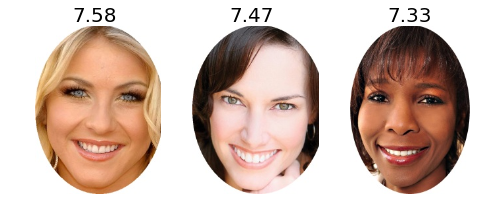

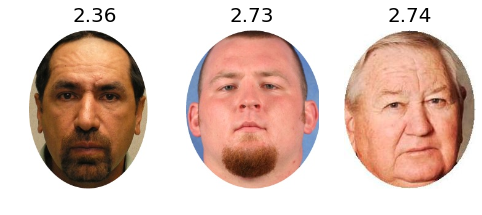

In [16]:
imListNP = np.asarray(imList)
minImage = imListNP[minIndex]
maxImage = imListNP[maxIndex]
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3), sharex=True, sharey=True)

ax1.imshow(plt.imread(maxImage[-1]))
ax1.axis('off')
ax1.set_title(str("{0:.2f}".format(maxRating[-1])), fontsize=20)

ax2.imshow(plt.imread(maxImage[-2]))
ax2.axis('off')
ax2.set_title(str("{0:.2f}".format(maxRating[-2])), fontsize=20)

ax3.imshow(plt.imread(maxImage[-3]))
ax3.axis('off')
ax3.set_title(str("{0:.2f}".format(maxRating[-3])), fontsize=20)


# ax4.imshow(edges3, cmap=plt.cm.gray)
# ax4.axis('off')
# ax4.set_title('auto', fontsize=20)



fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3), sharex=True, sharey=True)

ax1.imshow(plt.imread(minImage[0]))
ax1.axis('off')
ax1.set_title(str("{0:.2f}".format(minRating[0])), fontsize=20)

ax2.imshow(plt.imread(minImage[1]))
ax2.axis('off')
ax2.set_title(str("{0:.2f}".format(minRating[1])), fontsize=20)

ax3.imshow(plt.imread(minImage[2]))
ax3.axis('off')
ax3.set_title(str("{0:.2f}".format(minRating[2])), fontsize=20)


# ax4.imshow(edges3, cmap=plt.cm.gray)
# ax4.axis('off')
# ax4.set_title('auto', fontsize=20)



In [ ]:
np.savetxt(saveFigPath+'/'+featureLayer+'_feature_pca_atrr.csv', feature_transf, delimiter=',')

In [ ]:
ratingPath = '../Result/'+Dataset+'/meanRating.csv'
mean_rating = pd.read_csv(ratingPath,index_col = 0).as_matrix()[:,0].tolist()
mean_rating = map(float, mean_rating)
mean_rating = np.array(mean_rating)

baseLine = mean_rating.mean()
print 'mean rating: ', baseLine

MODEL_ARR = ['vgg16']#,'caffeNet','vggFace']
caffe.set_device(1)
caffe.set_mode_gpu()
for MODEL in MODEL_ARR:
    print 'MODEL: '+MODEL
    saveFigPath = '../Result/'+Dataset+'/'+MODEL
    if not os.path.exists(saveFigPath):
        os.makedirs(saveFigPath)

    if MODEL == 'vgg16':
        MODEL_FILE = caffe_root +'models/VGG16/VGG_ILSVRC_16_layers_deploy.prototxt'
        PRETRAINED_FILE = caffe_root + 'models/VGG16/VGG_ILSVRC_16_layers.caffemodel'
    elif MODEL == 'caffeNet':
        MODEL_FILE = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
        PRETRAINED_FILE = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
    else: 
        #MODEL == 'vggFace'
        MODEL_FILE = caffe_root + 'models/VGGFACE/VGG_CNN_F_deploy.prototxt'
        PRETRAINED_FILE = caffe_root + 'models/VGGFACE/VGG_CNN_F.caffemodel'
        MEAN_FILE = caffe_root + 'models/VGGFACE/VGG_mean.binaryproto'

    if not os.path.isfile(PRETRAINED_FILE):
        print("No caffemodel!!!")
    elif not os.path.isfile(MODEL_FILE):
        print("No MODEL !!!")
    else:
        print "Defining the net!"
        net = caffe.Net(MODEL_FILE,
                    PRETRAINED_FILE,
                    caffe.TEST)
    # input preprocessing: 'data' is the name of the input blob == net.inputs[0]
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
    # subtract the dataset-mean value in each channel
    transformer.set_mean('data', mu)
    transformer.set_transpose('data', (2,0,1))
    # the reference model operates on images in [0,255] range instead of [0,1]
    transformer.set_raw_scale('data', 255) 
    # the reference model has channels in BGR order instead of RGB
    transformer.set_channel_swap('data', (2,1,0))
    plt.rcParams['figure.figsize'] = (10, 10)
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'

    if MODEL == 'vgg16' or MODEL == 'vggFace':
        imgeReshape = [224,224]
    else:
        #MODEL == 'caffeNet'
        imgeReshape = [227,227]
    for layer_name, param in net.params.iteritems():
        print layer_name + '\t' + str(net.blobs[layer_name].data.shape), str(param[1].data.shape)  
    for layer_name, param in net.params.iteritems():
        featureLayer = layer_name
        print 'Layer Set up: '+MODEL+' '+featureLayer
        if 'fc' in featureLayer:
            featureNum = net.params[featureLayer][1].data.shape[0]
        else:
            featureNum = net.blobs[featureLayer].data.flatten().shape[0]/net.blobs[featureLayer].data.shape[0]
        features = np.zeros([len(imList),featureNum])
        totalNum = 0

        # print len(imList)
        for img in imList:
            imgName = os.path.basename(img)
            if imgName.endswith(('.jpg','.png')):
                input_image = caffe.io.load_image(img)
                net.blobs['data'].reshape(1,3,imgeReshape[0],imgeReshape[1])
                net.blobs['data'].data[...] = transformer.preprocess('data', input_image)
                out = net.forward()
                feat = net.blobs[featureLayer].data
#                 print feat.shape
                features[totalNum] = feat.flatten()
                totalNum +=1
            else:
                print img
        print totalNum
        featureMat = features
        
        explained_variance = 0.99
        sklearn_pca = sklearnPCA(n_components=explained_variance, whiten  = True)
        feature_transf = sklearn_pca.fit_transform(featureMat)
        print 'The number of PCs needed to retain %.3f variance is %d.' \
              % (explained_variance, feature_transf.shape[1])
        predictionModel = sklearn.linear_model.RidgeCV(alphas=np.logspace(-3,2,num=20), fit_intercept=True)
        Train_Test(mean_rating, feature_transf,xVal = True, pModel = predictionModel,\
                       numTrain = 50,savePath = '../Result/'+Dataset,MODEL= MODEL)
        print 'One layer done!'
        print '######################################'
        print '######################################'
    print 'One MODEL done!'
    print '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'
    print '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!'

mean rating:  4.938305509
MODEL: vgg16
Defining the net!
conv1_1	(10, 64, 224, 224) (64,)
conv1_2	(10, 64, 224, 224) (64,)
conv2_1	(10, 128, 112, 112) (128,)
conv2_2	(10, 128, 112, 112) (128,)
conv3_1	(10, 256, 56, 56) (256,)
conv3_2	(10, 256, 56, 56) (256,)
conv3_3	(10, 256, 56, 56) (256,)
conv4_1	(10, 512, 28, 28) (512,)
conv4_2	(10, 512, 28, 28) (512,)
conv4_3	(10, 512, 28, 28) (512,)
conv5_1	(10, 512, 14, 14) (512,)
conv5_2	(10, 512, 14, 14) (512,)
conv5_3	(10, 512, 14, 14) (512,)
fc6	(10, 4096) (4096,)
fc7	(10, 4096) (4096,)
fc8	(10, 1000) (1000,)
Layer Set up: vgg16 conv1_1
2222


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd
# Load image dataset#
Dataset = 'mit' # 'twin', 'chicago' or 'mit'
if Dataset == 'twin':
    imPath = '../../processing/imageProcessing/paddedImages/'
    ext = '.png'
elif Dataset == 'chicago':
    imPath = '../../ChicagoFaceDataset/CFD Version 2.0/CFD 2.0 Images/'
    ext = 'N.jpg'
else:
    imPath = '../../MIT2kFaceDataset/2kfaces/'
    ext = '.jpg'
geometric_matrix = pd.read_csv('../../MIT2kFaceDataset/clean_data/geometric_all.csv',index_col = 0)
imList = geometric_matrix.imgName.tolist()
imList = [imPath+ imgStr for imgStr in imList]
print len(imList)
print imPath

# Make sure that caffe is on the python path:
caffe_root = '/home/lli-ms/caffe/'
pretrained_model_root = '/home/lli-ms/caffe/'

# run this line one time only!
import sys
caffePython = pretrained_model_root + 'python'
if caffePython not in sys.path:
    sys.path.insert(0, caffePython)


import caffe
# Load mean
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# Load the trained net
MODEL = 'caffeNet' #'caffeNet','vgg16','vggFace' or 'faceSNN'

saveFigPath = '../Result/'+Dataset+'/'+MODEL
if not os.path.exists(saveFigPath):
    os.makedirs(saveFigPath)
    
if MODEL == 'vgg16':
    MODEL_FILE = caffe_root +'models/VGG16/VGG_ILSVRC_16_layers_deploy.prototxt'
    PRETRAINED_FILE = caffe_root + 'models/VGG16/VGG_ILSVRC_16_layers.caffemodel'
elif MODEL == 'caffeNet':
    MODEL_FILE = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
    PRETRAINED_FILE = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
elif MODEL == 'vggFace':
    MODEL_FILE = caffe_root + 'models/VGGFACE/VGG_CNN_F_deploy.prototxt'
    PRETRAINED_FILE = caffe_root + 'models/VGGFACE/VGG_CNN_F.caffemodel'
    MEAN_FILE = caffe_root + 'models/VGGFACE/VGG_mean.binaryproto'
else:
    MODEL = 'faceSNN'
    MODEL_FILE = caffe_root +'models/sraonet/siamese_lecun_deploy.prototxt'
    PRETRAINED_FILE = caffe_root + 'models/sraonet/snapshots/sraonet_lecun_gd_sub2_iter_100000.caffemodel'
    
caffe.set_device(1)
caffe.set_mode_gpu()
if not os.path.isfile(PRETRAINED_FILE):
    print("No caffemodel!!!")
elif not os.path.isfile(MODEL_FILE):
    print("No MODEL !!!")
else:
    print "Defining the net!"
    net = caffe.Net(MODEL_FILE,
                PRETRAINED_FILE,
                caffe.TEST)
# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
if MODEL != 'faceSNN':
    # subtract the dataset-mean value in each channel
    transformer.set_mean('data', mu)
    print 'featureNum: ',net.params['fc7'][1].data.shape
else:
    print 'featureNum: ',net.params['fc6'][1].data.shape
transformer.set_transpose('data', (2,0,1))
# the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_raw_scale('data', 255) 
# the reference model has channels in BGR order instead of RGB
transformer.set_channel_swap('data', (2,1,0))
# read in image list 
def readFile(fName):
    text_file = open(fName, "r")
    lines = text_file.read().split('\n')
    text_file.close()
    return lines

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

if MODEL == 'vgg16' or MODEL == 'vggFace':
    featureNum = 4096
    imgeReshape = [224,224]
    featureLayer = 'fc7'
elif MODEL == 'caffeNet':
    featureNum = 4096
    imgeReshape = [227,227]
    featureLayer = 'fc7'
else:
    featureNum = 50
    imgeReshape = [56,46]
    featureLayer = 'fc6'

if Dataset == 'twin':
    features = np.zeros([4,len(imList)/4,featureNum])
    perImNum = len(imList)/4
    img_type_num = {}
    img_type_index = {}
    img_type_list = {}
    type_index = 0
else:
    features = np.zeros([len(imList),featureNum])
totalNum = 0

# print len(imList)
for img in imList:
    imgName = os.path.basename(img)
    if imgName.endswith(('.jpg','.png')):
        input_image = caffe.io.load_image(img)
        net.blobs['data'].reshape(1,3,imgeReshape[0],imgeReshape[1])
        net.blobs['data'].data[...] = transformer.preprocess('data', input_image)
        out = net.forward()
        feat = net.blobs[featureLayer].data
        if Dataset =='twin':
            img_type = int(imgName[7:-4])/perImNum
            img_index = int(imgName[7:-4])%perImNum
            #print 'img_type:',img_type
            if img_type in img_type_num.keys():
                img_type_num[img_type] = img_type_num[img_type] + 1
                img_type_list[img_type][img_index] = img
            else:
                img_type_num[img_type] = 0
                img_type_list[img_type] = [None]*perImNum
                img_type_index[img_type] = type_index
                type_index +=1
            #print 'img_type_index:',img_type_index[img_type]
            features[img_type_index[img_type],img_type_num[img_type]] = feat.flatten()
        else:
            # need to be further revised!
            features[totalNum] = feat.flatten()
            #print features[totalNum]
        totalNum +=1
    else:
        print img
#print len(img_type_num)
print totalNum
#print img_type_list

if Dataset == 'twin':
    featureMat = np.zeros((totalNum,featureNum))
    k = 0
    for i in range(features.shape[0]):
        for j in range(features[i].shape[0]):
            if sum(features[i,j,:])!=0:
                featureMat[k,:] = features[i,j,:]
                k +=1
else:
    featureMat = features
#print featureMat

In [ ]:
from sklearn.decomposition import PCA as sklearnPCA
if MODEL != 'faceSNN':
    explained_variance = 0.99
    #explained_variance = 50
else:
    explained_variance = featureNum

config_feature = geometric_matrix.loc[:,'nose_width':'AV']
print config_feature.columns 
feature_combine = np.concatenate((config_feature,featureMat),axis = 1)
sklearn_pca = sklearnPCA(n_components=explained_variance, whiten  = True)
feature_combine_transf = sklearn_pca.fit_transform(feature_combine)
print 'The number of PCs needed to retain %.3f variance is %d.' \
      % (explained_variance, feature_combine_transf.shape[1])
    
sklearn_pca = sklearnPCA(n_components=explained_variance, whiten  = True)
feature_transf = sklearn_pca.fit_transform(featureMat)
print 'The number of PCs needed to retain %.3f variance is %d.' \
      % (explained_variance, feature_transf.shape[1])


sklearn_pca = sklearnPCA(n_components=explained_variance, whiten  = True)
config_transf = sklearn_pca.fit_transform(config_feature)
print 'The number of PCs needed to retain %.3f variance is %d.' \
      % (explained_variance, config_transf.shape[1])

In [ ]:
mean_rating = geometric_matrix.attractive.as_matrix()
print len(mean_rating)
mean_rating = map(float, mean_rating)
mean_rating = np.array(mean_rating)
import sys
#print sys.path
# local
# PkgPath = '/Users/Olivialinlin/Documents/Github/attractiveness_datamining/linjieCode/code'
# server
PkgPath = '/home/lli-ms/attractiveness_datamining/linjieCode/code'

if PkgPath not in sys.path:
    sys.path.insert(0, PkgPath)
#print sys.path
from xVal_train_test import Train_Test
import pandas as pd
feature_transf = feature_combine_transf #np.concatenate((config_transf,feature_transf),axis = 1)
print feature_transf.shape
baseLine = mean_rating.mean()
print 'mean rating: ', baseLine
import sklearn
predictionModel = sklearn.linear_model.RidgeCV(alphas=np.logspace(-3,2,num=20), fit_intercept=True)
Train_Test(mean_rating, feature_transf,xVal = True, pModel = predictionModel,\
               numTrain = 100,savePath = '../Result/'+Dataset,MODEL= MODEL)

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import linear_model
ratingPath = '../Result/'+Dataset+'/meanRating.csv'
mean_rating = pd.read_csv(ratingPath,index_col = 0).as_matrix()[:,0].tolist()
mean_rating = map(float, mean_rating)
mean_rating = np.array(mean_rating)

baseLine = mean_rating.mean()
print 'mean rating: ', baseLine
# cross validation to determine the number of features
from sklearn import cross_validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(\
                       feature_transf, mean_rating, test_size=0.2, random_state=0)
corrList = []
varList = []
mseList = []
if MODEL != 'faceSNN':
    numFeature = [40,50,60,65,70,75,80,90,100,120,150,200,250,300,350]
else:
    numFeature = [10,20,30,40,50]
for numF in numFeature:
    X_train_hat = X_train[:,:numF]
#     print X_train_hat.shape
#     print y_train.shape
    X_test_hat = X_test[:,:numF]
    # Do linear regression on feature_arr and mean_rating
    regr = linear_model.Ridge(fit_intercept=True)
    regr.fit(X_train_hat, y_train)
    predicted_rating = regr.predict(X_test_hat)
    #rectified_rating = np.around(predicted_rating, decimals=0)
    # Calculate the mean square error
    MSE = np.mean((predicted_rating - y_test) ** 2)
    mseList.append(MSE)
    
    # Returns the coefficient of determination R^2 of the prediction.
    '''
    The coefficient R^2 is defined as (1 - u/v), 
    where u is the regression sum of squares ((y_true - y_pred) ** 2).sum() 
    and v is the residual sum of squares ((y_true - y_true.mean()) ** 2).sum(). 
    Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).
    A constant model that always predicts the expected value of y, 
    disregarding the input features, would get a R^2 score of 0.0.
    '''
    variance_score = regr.score(X_test_hat, y_test)
    varList.append(variance_score)
    
    # Calculate the correlation between prediction and actual rating.
    cor = np.corrcoef(predicted_rating, y_test)
    corrList.append(cor[0,1])

print 'Correlation: ', max(corrList)
print 'num of features: ',numFeature[np.argmax(corrList)]
print 'R^2 score: ',max(varList)
print 'num of features: ',numFeature[np.argmax(varList)]
print 'MSE: ',min(mseList)
print 'num of features: ',numFeature[np.argmin(mseList)]
optNumFea = numFeature[np.argmax(corrList)]
X_train_hat = X_train[:,:optNumFea]
X_test_hat = X_test[:,:optNumFea]

In [ ]:
# Do linear regression on feature_arr and mean_rating
regr = linear_model.Ridge(fit_intercept=True)
regr.fit(X_train_hat, y_train)
predicted_rating = regr.predict(X_train_hat)
#rectified_rating = np.around(predicted_rating, decimals=0)

# The coefficients
#print 'Coefficients: ', regr.coef_[0:10]
print 'Intercept: ', regr.intercept_
# Calculate the mean square error
MSE = np.mean((predicted_rating - y_train) ** 2)
print 'Residual sum of squares: %.2f' % MSE

# Calculate how much variance is explained
variance_score = regr.score(X_train_hat, y_train)
print 'Variance score is: %.2f' % variance_score

# Calculate the correlation between prediction and actual rating.
cor = np.corrcoef(predicted_rating, y_train)
print 'Correlation is: %.2f' %cor[0, 1]

fName = saveFigPath+'/'+MODEL+'_training.txt'
with open(fName,'w') as f:
    f.write('Training Accuracy\n')
    f.write('Number of features: %d'%X_train_hat.shape[1] +'\n')
    f.write('Residual sum of squares: %.2f' %MSE+'\n')
    f.write('Variance score is: %.2f' %variance_score+'\n')
    f.write('Correlation between predicted ratings and actual ratings is: %.4f'\
            %cor[0,1]+'\n')  
# # Plot prediction vs actual rating.
x = predicted_rating
y = y_train
fig, ax = plt.subplots()
ax.scatter(x, y, alpha=0.5)
ax.set_xlim((0, 8))
ax.set_ylim((0, 8))
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.set_aspect(abs(x1-x0)/abs(y1-y0))
ax.grid(b=True, which='major', color='k', linestyle='--')
m, b = np.polyfit(x, y, 1)
X_plot = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],100)
plt.plot(X_plot, m*X_plot + b, '-r')
plt.xlabel('Predicted Ratings',fontsize = 26)
plt.ylabel('Actual Ratings',fontsize = 26)
plt.title('Predicted VS Actual Ratings',fontsize = 26)
plt.savefig(saveFigPath+'/'+MODEL+'_predVsActual.png')

In [ ]:
# k-fold#
from sklearn.cross_validation import KFold
imgNum = feature_transf.shape[0]
foldNum = 20
kf = KFold(imgNum, n_folds=foldNum, shuffle=True)
print(kf)

corrList = []
varList = []
mseList = []
feature_new = feature_transf[:,:optNumFea]
for train_index, test_index in kf:
    feature_train, feature_test = feature_new[train_index], feature_new[test_index]
    rating_train, rating_test = mean_rating[train_index], mean_rating[test_index]
    
    # Do linear regression on feature_arr and mean_rating
    regr = linear_model.LinearRegression(fit_intercept=True)
    regr.fit(feature_train, rating_train)
    predicted_rating = regr.predict(feature_test)

    # Calculate the mean square error
    MSE = np.mean((predicted_rating - rating_test) ** 2)
    mseList.append(MSE)
    
    # Returns the coefficient of determination R^2 of the prediction.
    variance_score = regr.score(feature_test, rating_test)
    varList.append(variance_score)
    
    # Calculate the correlation between prediction and actual rating.
    cor = np.corrcoef(predicted_rating, rating_test)
    corrList.append(cor[0,1])
    
print 'Residual sum of squares: %.2f' % (sum(mseList)/foldNum)
print 'Variance score is: %.2f' % (sum(varList)/foldNum)
print 'Correlation between predicted ratings and actual ratings is: %.4f'%(sum(corrList)/foldNum)

fName = saveFigPath+'/'+MODEL+'_kFold.txt'
with open(fName,'w') as f:
    f.write('Number of folds: %d' % foldNum +'\n')
    f.write('Residual sum of squares: %.2f' % (sum(mseList)/foldNum)+'\n')
    f.write('Variance score is: %.2f' % (sum(varList)/foldNum)+'\n')
    f.write('Correlation between predicted ratings and actual ratings is: %.4f'\
            %(sum(corrList)/foldNum)+'\n')

In [ ]:
import pickle
np.savetxt(saveFigPath+'/feature_pca_atrr.csv', feature_new, delimiter=',')
#np.savetxt(saveFigPath+'/feature_atrr.csv',featureMat,delimiter = ',')
if Dataset == 'twin':
    img_index_name_map = dict()
    for key in img_type_list.keys():
        img_index_name_map[img_type_index[key]] = img_type_list[key]
    with open('../Result/'+Dataset+'/attr_imgIndex_name.pickle', 'wb') as handle:
        pickle.dump(img_index_name_map, handle)